Columns in final_df: ['new_minute_index', 'carparkName', 'availableEvChargingSpace', 'totalEvChargingSpace', 'Collected timestamp', 'usage', 'date']
   new_minute_index carparkName  availableEvChargingSpace  \
0                 0          P2                       6.0   
1                 1          P2                       6.0   
2                 2          P2                       6.0   
3                 3          P2                       6.0   
4                 4          P2                       6.0   

   totalEvChargingSpace Collected timestamp     usage        date  
0                  29.0 2024-11-13 00:38:47  0.793103  2024-11-13  
1                  29.0 2024-11-13 00:38:47  0.793103  2024-11-13  
2                  29.0 2024-11-13 00:38:47  0.793103  2024-11-13  
3                  29.0 2024-11-13 00:38:47  0.793103  2024-11-13  
4                  29.0 2024-11-13 00:38:47  0.793103  2024-11-13  


/var/folders/sj/2p6wz56s1ydg4dt60j2x0ppw0000gn/T/ipykernel_36411/2856208364.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")


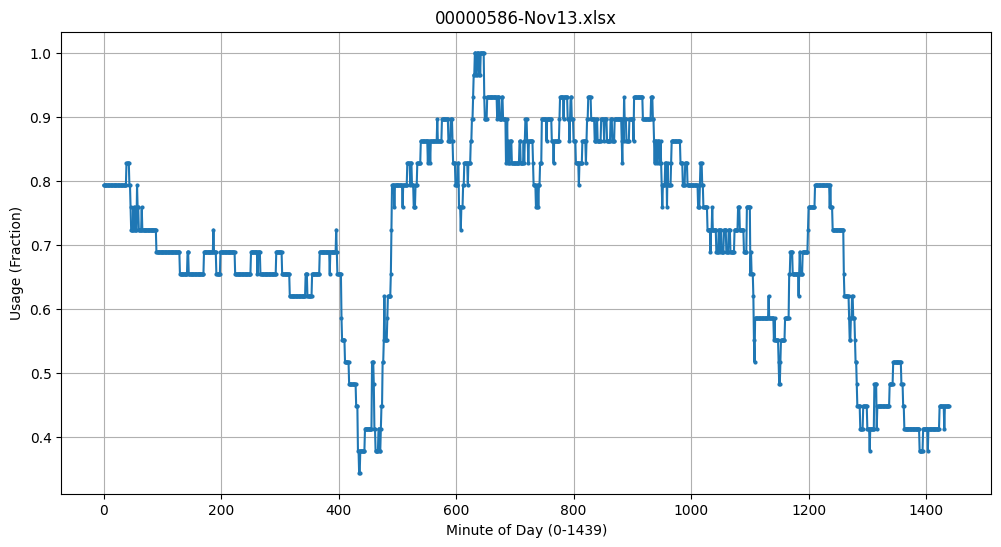

In [3]:
import pandas as pd
import glob
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Specify the directory and file pattern for your XLSX files.
file_pattern = "00000586-Nov13.xlsx"  # Replace with your folder path
files = glob.glob(file_pattern)

# List to hold the cleaned DataFrames (one per day/file)
cleaned_days = []

for file in files:
    try:
        # Read the Excel file using the openpyxl engine.
        df = pd.read_excel(file, engine='openpyxl')
    except Exception as e:
        print(f"Error reading {file}: {e}")
        continue

    # 1. Keep only the required columns.
    required_cols = [
        "carparkName", 
        "availableEvChargingSpace", 
        "totalEvChargingSpace", 
        "Collected timestamp"
    ]
    df = df[required_cols]

    # 2. Filter rows for carparkName 'P2'
    df = df[df["carparkName"] == "P2"]

    # 3. Convert "Collected timestamp" to datetime.
    df["Collected timestamp"] = pd.to_datetime(df["Collected timestamp"])

    # Determine the day of the data (we assume one file per day)
    unique_dates = df["Collected timestamp"].dt.date.unique()
    if len(unique_dates) != 1:
        print(f"Warning: {file} contains data for multiple days. Using the first date encountered.")
    day_date = unique_dates[0]
    
    # Define day's start and the expected day’s end (midnight of the next day)
    day_start = pd.Timestamp(datetime.combine(day_date, datetime.min.time()))
    day_end = day_start + pd.Timedelta(days=1)  # This is 24:00 or 00:00 of the next day

    # 4. Identify the anchor row (the record closest to day_end)
    df["delta"] = (day_end - df["Collected timestamp"]).abs()
    anchor_idx = df["delta"].idxmin()
    T_anchor = df.loc[anchor_idx, "Collected timestamp"]

    # 5. Create a new minute index.
    # We want the row at T_anchor to be at minute index 1439.
    df["new_minute_index"] = 1439 - (
        (T_anchor - df["Collected timestamp"]).dt.total_seconds() / 60
    ).astype(int)
    
    # 6. Sort the DataFrame by new_minute_index and reindex so that every minute (0 to 1439) is present.
    df = df.set_index("new_minute_index").sort_index()
    complete_index = range(1440)  # 0 to 1439
    df = df.reindex(complete_index)
    # Fill missing rows by first forward filling then backward filling if necessary.
    df = df.fillna(method="ffill").fillna(method="bfill")
    
    # 7. Compute the usage metric as a fraction.
    # usage = (totalEvChargingSpace - availableEvChargingSpace) / totalEvChargingSpace
    df["usage"] = (df["totalEvChargingSpace"] - df["availableEvChargingSpace"]) / df["totalEvChargingSpace"]

    # 8. Record the actual date for later reference.
    df["date"] = day_date

    # Drop the temporary column ("delta")
    df = df.drop(columns=["delta"], errors='ignore')
    
    # Append cleaned dataframe for this day to our list
    cleaned_days.append(df)

# Combine the data from all days into one DataFrame.
# Since each day’s DataFrame uses the minute index (0 to 1439), we use ignore_index=False.
final_df = pd.concat(cleaned_days, ignore_index=False)

# Reset the index so that our index becomes a column.
# The old index gets moved into a column named "index". We then rename it to "minute_index".
final_df = final_df.reset_index().rename(columns={"index": "minute_index"})

# DEBUG: Print the columns to verify that "minute_index" is present.
print("Columns in final_df:", final_df.columns.tolist())
print(final_df.head())

# --- Plotting ---
plt.figure(figsize=(12, 6))
plt.plot(final_df["new_minute_index"], final_df["usage"], marker="o", markersize=2)
plt.xlabel("Minute of Day (0-1439)")
plt.ylabel("Usage (Fraction)")
plt.title(file_pattern)
plt.grid(True)
plt.show()

Estimated arrival rate λ (per minute): 0.10979847116052814
Estimated service rate μ (per minute): 0.11674774148714386
Estimated arrival rate λ (per hour): 6.587908269631688
Estimated service rate μ (per hour): 7.004864489228631


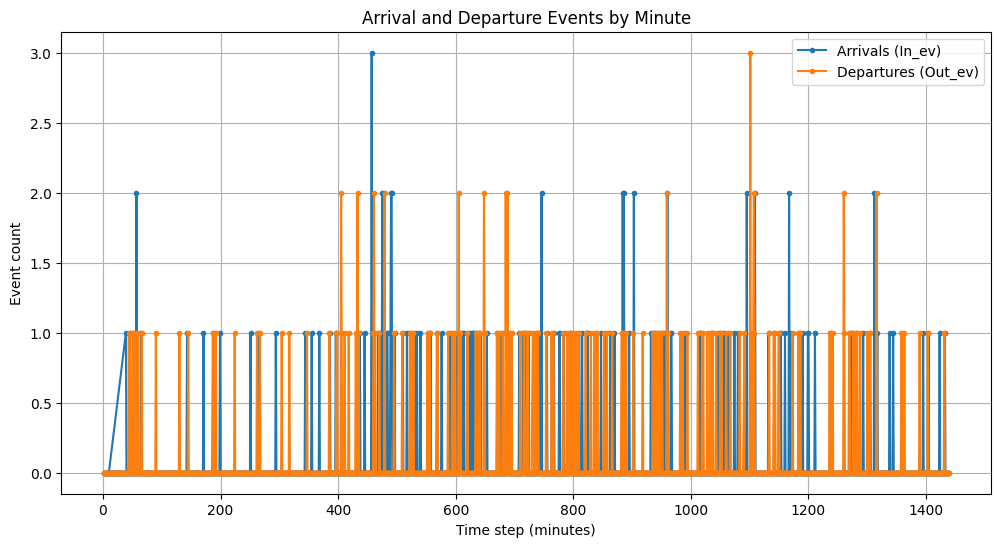

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Suppose df is your DataFrame and it has a column "UsedEvChargingSpace"
# If you need to compute it from totalEvChargingSpace and availableEvChargingSpace,
# you could do:
df["UsedEvChargingSpace"] = df["totalEvChargingSpace"] - df["availableEvChargingSpace"]

# Make sure the data is sorted by time (if time is also a column, sort by it)
# For example:
df = df.sort_values("Collected timestamp")

# 1. Compute the minute-to-minute change.
df["Change"] = df["UsedEvChargingSpace"].diff()  # Change[t] = Used[t] - Used[t-1]

# 2. Identify arrivals and departures.
# If Change > 0: arrival. If Change < 0: departure.
df["In_ev"] = df["Change"].apply(lambda x: x if x > 0 else 0)
df["Out_ev"] = df["Change"].apply(lambda x: -x if x < 0 else 0)

# Optionally, drop the first row since diff() produces a NaN for the first element.
df = df.dropna(subset=["Change"])

# 3. Compute λ and μ
# The total number of minutes where changes are recorded:
total_minutes = len(df)

# Total arrivals and departures over the time period
total_arrivals = df["In_ev"].sum()
total_departures = df["Out_ev"].sum()

# Since our data is per minute, lambda and mu are estimated in arrivals/departures per minute.
lambda_estimate = total_arrivals / total_minutes
mu_estimate = total_departures / total_minutes

print(f"Estimated arrival rate λ (per minute): {lambda_estimate}")
print(f"Estimated service rate μ (per minute): {mu_estimate}")

# (Optional) Multiply by 60 if you prefer rates per hour:
print(f"Estimated arrival rate λ (per hour): {lambda_estimate * 60}")
print(f"Estimated service rate μ (per hour): {mu_estimate * 60}")

# 4. (Optional) Plot the In_ev and Out_ev over time to visualize the events
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["In_ev"], label="Arrivals (In_ev)", marker="o", markersize=3)
plt.plot(df.index, df["Out_ev"], label="Departures (Out_ev)", marker="o", markersize=3)
plt.xlabel("Time step (minutes)")
plt.ylabel("Event count")
plt.title("Arrival and Departure Events by Minute")
plt.legend()
plt.grid(True)
plt.show()

Estimated arrival rate λ (per minute): 0.10987482614742698
Estimated arrival rate λ (per hour): 6.592489568845619


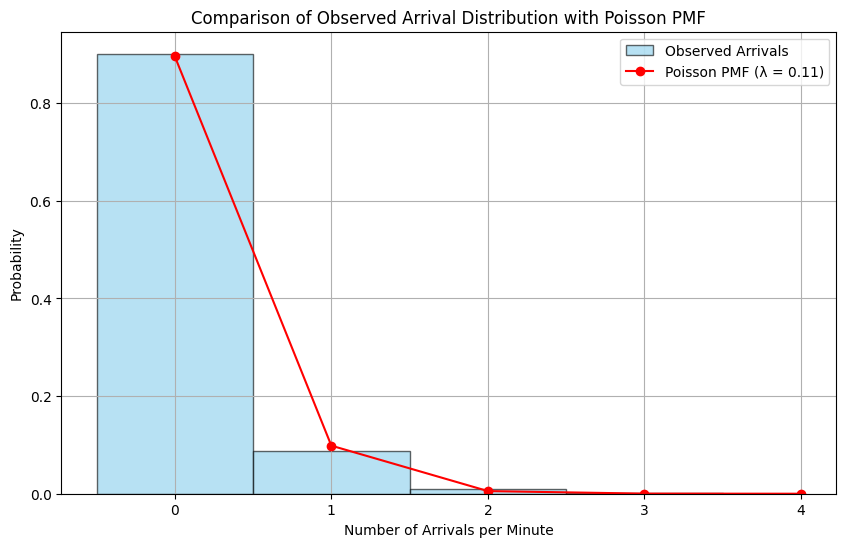

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# === Prepare the Data ===
# Assume df is your DataFrame and it already contains a "UsedEvChargingSpace" column.
# If necessary, compute it first (for example, from total and available spaces):
# df["UsedEvChargingSpace"] = df["totalEvChargingSpace"] - df["availableEvChargingSpace"]

# Make sure the data is sorted chronologically. If you have a timestamp column, e.g. "Collected timestamp":
# df = df.sort_values("Collected timestamp")

# 1. Compute the minute-to-minute change.
df["Change"] = df["UsedEvChargingSpace"].diff()

# The first row will have a NaN change, so remove it.
df = df.dropna(subset=["Change"])

# 2. Identify arrivals and departures.
#   - Arrivals (In_ev): Change[t] if positive, else 0.
#   - Departures (Out_ev): (- Change[t]) if negative, else 0.
df["In_ev"] = df["Change"].apply(lambda x: x if x > 0 else 0)
df["Out_ev"] = df["Change"].apply(lambda x: -x if x < 0 else 0)

# === Calculate Arrival Rate (λ) ===
# Since data is captured per minute, we estimate λ as the average arrivals per minute.
lambda_est = df["In_ev"].mean()
print(f"Estimated arrival rate λ (per minute): {lambda_est}")
print(f"Estimated arrival rate λ (per hour): {lambda_est * 60}")

# === Plot the Arrival Rate Histogram with Overlaid Poisson PMF ===

# Determine the range for display.
max_arrivals = int(df["In_ev"].max())

# Create x-values: observed counts are integers from 0 to max_arrivals (plus a little margin)
x = np.arange(0, max_arrivals + 2)

# Compute the theoretical Poisson PMF for these x-values using the estimated λ.
poisson_pmf = poisson.pmf(x, lambda_est)

plt.figure(figsize=(10, 6))
# Plot histogram for observed In_ev counts.
# We use bins that center at each integer value.
plt.hist(df["In_ev"], bins=np.arange(-0.5, max_arrivals + 1.5, 1),
         density=True, alpha=0.6, color='skyblue', edgecolor='black',
         label="Observed Arrivals")

# Overlay the theoretical Poisson PMF.
plt.plot(x, poisson_pmf, 'o-', color='red', label=f"Poisson PMF (λ = {lambda_est:.2f})")

plt.xlabel("Number of Arrivals per Minute")
plt.ylabel("Probability")
plt.title("Comparison of Observed Arrival Distribution with Poisson PMF")
plt.legend()
plt.grid(True)
plt.show()